# Test Gauss-Newton plane-based registration

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import os

import planeslam.io as io
from planeslam.general import plot_3D_setup, color_legend
from planeslam.scan import pc_to_scan
from planeslam.registration import extract_corresponding_features, get_correspondences, residual, jacobian

%load_ext autoreload
%autoreload 2

torch libraries not found, skipping import


Read in airsim LiDAR and pose data

In [2]:
# Read in point cloud data
binpath = os.path.join(os.getcwd(), '..', '..', 'data', 'airsim', 'blocks_20_samples_1', 'lidar', 'Drone0')
PC_data = io.read_lidar_bin(binpath)

In [3]:
# Read in ground-truth poses (in drone local frame)
posepath = os.path.join(os.getcwd(), '..', '..', 'data', 'airsim', 'blocks_20_samples_1', 'poses', 'Drone0')
drone_positions, drone_orientations = io.read_poses(posepath)

Extract planes 

In [4]:
num_scans = len(PC_data)
scans = num_scans * [None]
scans_transformed = num_scans * [None]
for i in range(num_scans):
    scans[i] = pc_to_scan(PC_data[i])

Get correspondences

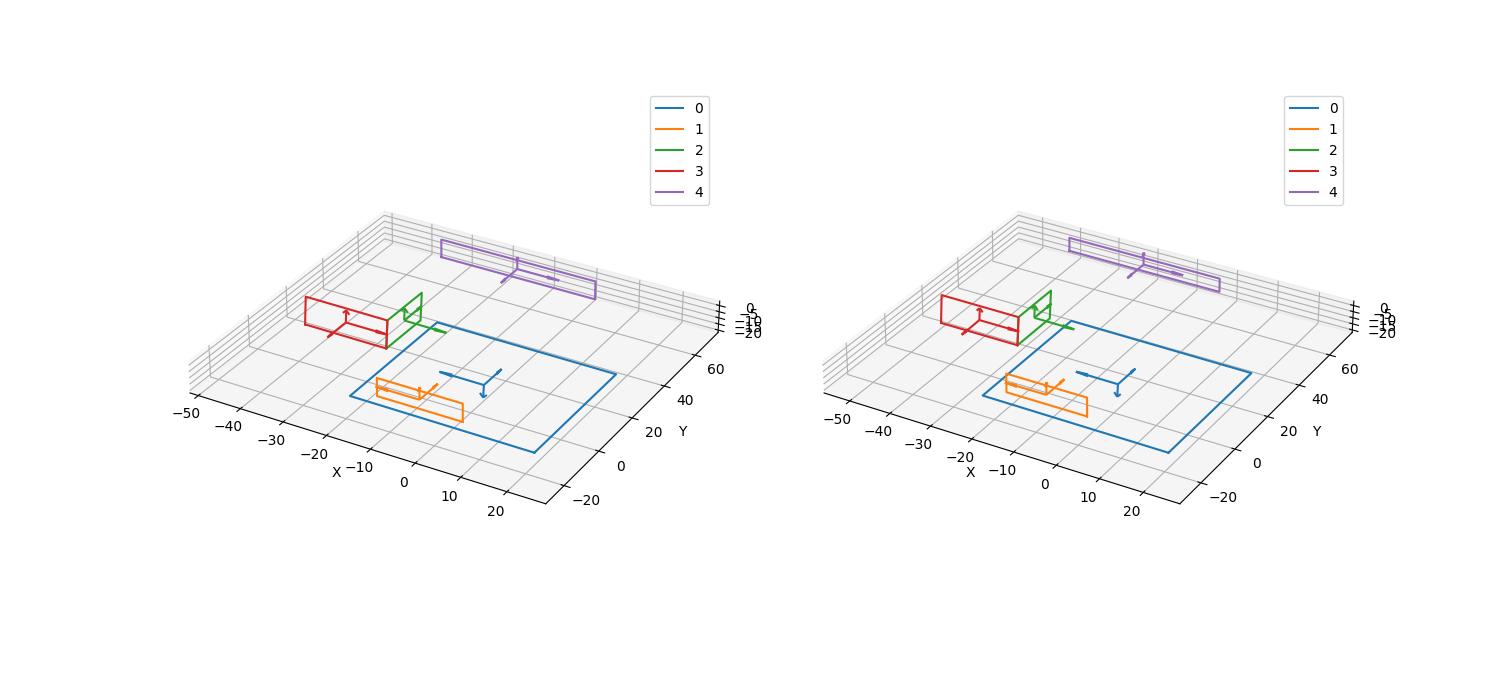

In [5]:
idx_1 = 9
idx_2 = 10

# Plot 2 scans
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

ax1.set_box_aspect((np.ptp(PC_data[0][:,0]), np.ptp(PC_data[0][:,1]), np.ptp(PC_data[0][:,2])))
ax2.set_box_aspect((np.ptp(PC_data[0][:,0]), np.ptp(PC_data[0][:,1]), np.ptp(PC_data[0][:,2])))
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")

scans[idx_1].plot(ax1, show_normals=True)
scans[idx_2].plot(ax2, show_normals=True)

# Color legend
num_colors = max([len(s.planes) for s in scans[0:2]])
color_legend(ax1, num_colors)
color_legend(ax2, num_colors)

In [6]:
# Extract normals and distances
# Use idx_2 as source and idx_1 as target
correspondences = get_correspondences(scans[idx_2], scans[idx_1])
#correspondences = [(0,0), (1,1), (2,3), (3,4)]
n_s, d_s, n_t, d_t = extract_corresponding_features(scans[idx_2], scans[idx_1], correspondences)

Test Gauss-Newton registration

In [9]:
# Initial transformation
# t = np.array([0, 1, 0])[:,None]
# u = np.array([1, 0, 0])[:,None]
# theta = 0.1
# q = np.vstack((t, theta*u))
q = np.random.randn(6,1)

# Gauss-Newton
n_iters = 10
lmbda = 1e-8
mu = 5e-1

for i in range(n_iters):
    r, n_q = residual(n_s, d_s, n_t, d_t, q)
    print("loss: ", np.linalg.norm(r)**2)
    J = jacobian(n_s, n_q)
    q = q - mu * np.linalg.inv(J.T @ J + lmbda * np.eye(6)) @ J.T @ r

loss:  44.00460432376102
loss:  51.09771322995244
loss:  65.28286359579815
loss:  90.03487726464833
loss:  121.2571520832496
loss:  141.04679934796798
loss:  138.7777520181705
loss:  127.48329647103996
loss:  129.44371797638752
loss:  170.555426157853


In [11]:
q

array([[-3.4169724 ],
       [ 1.30405154],
       [-1.1900115 ],
       [ 2.49285016],
       [-0.28659417],
       [ 0.43578598]])

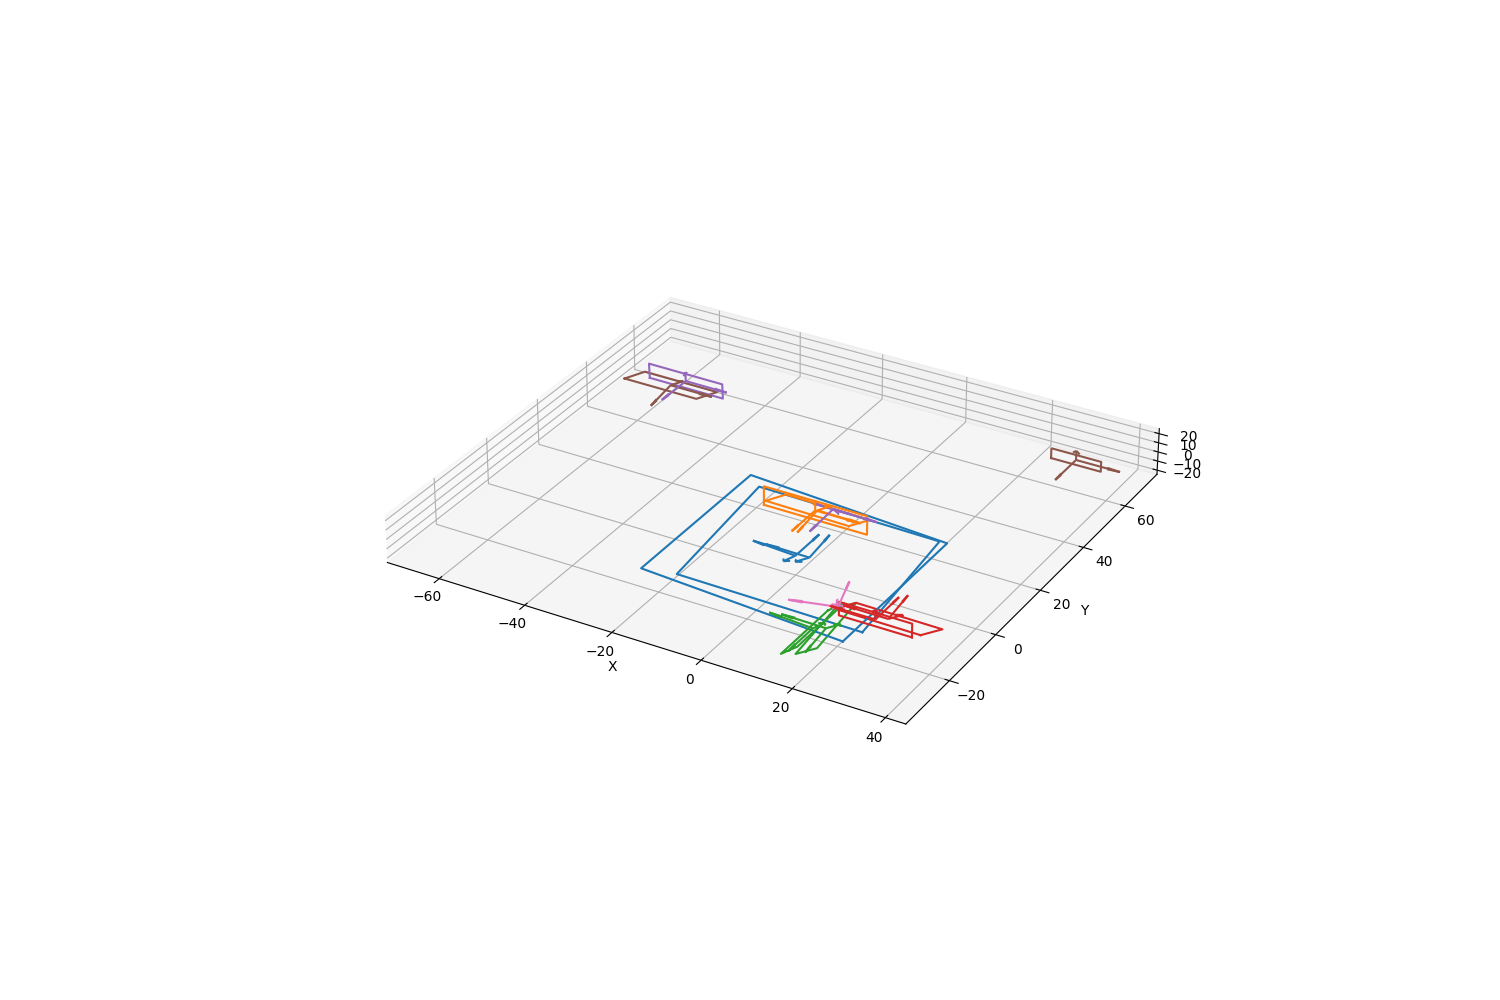

In [25]:
# Extract R and t from q
#t_est = q[:3]
t_est = np.zeros((3,1))
R_est = expmap(q[3:].flatten())

source_transformed = scans[0]
source_transformed.transform(R_est, t_est.flatten())
target = scans[1]

ax = plot_3D_setup(PC_data[0])

source_transformed.plot(ax, show_normals=True)
target.plot(ax, show_normals=True)


Test with two planes

In [12]:
from planeslam.geometry.plane import BoundedPlane
from planeslam.registration import expmap
from planeslam.scan import Scan
import copy

V1 = np.array([[-1, 1, -1],
              [1, 1, -1],
              [1, 1, 1],
              [-1, 1, 1]])
V2 = np.array([[-1, -1, -1],
              [-1, 1, -1],
              [-1, 1, 1],
              [-1, -1, 1]])
P = Scan([BoundedPlane(V1), BoundedPlane(V2)])

# Ground-truth transformation
t = np.array([0, -0.5, 0])[:,None]
u = np.array([0, 1, 0])[:,None]
theta = np.pi/12
q = np.vstack((t, theta*u))

R = expmap(q[3:].flatten())

print("t: ", t)
print("R: ", R)

vertex and face generation not yet implemented
t:  [[ 0. ]
 [-0.5]
 [ 0. ]]
R:  [[ 0.96592583  0.          0.25881905]
 [ 0.          1.          0.        ]
 [-0.25881905  0.          0.96592583]]


In [13]:
# P is source, Q is target
Q = copy.deepcopy(P)
Q.transform(R, t.flatten())

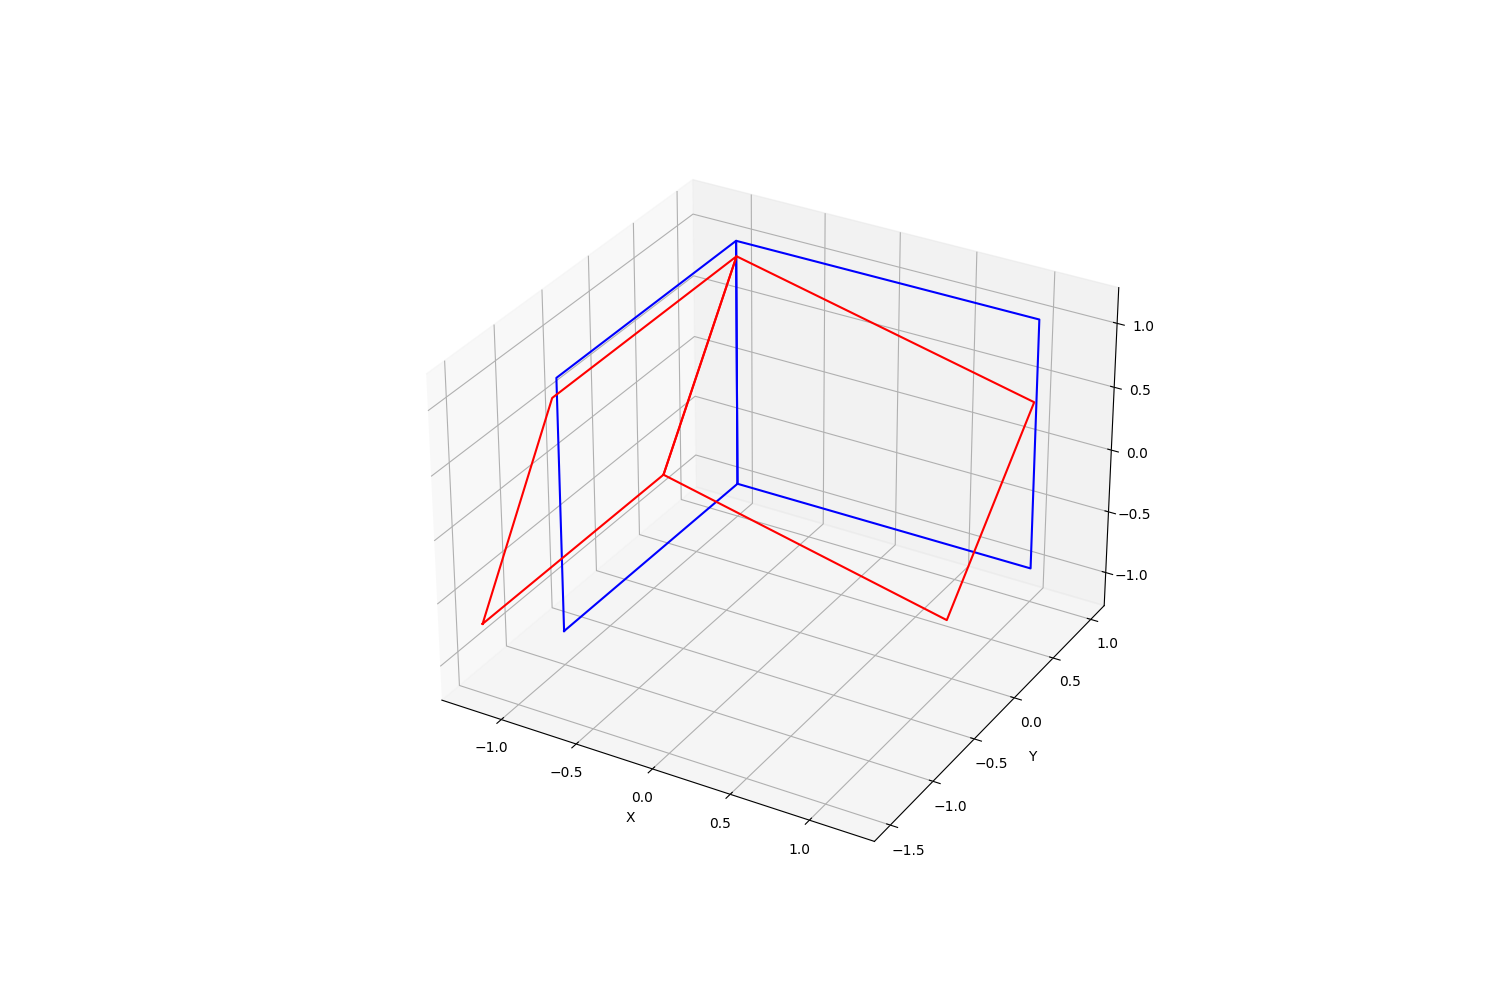

In [14]:
ax = plot_3D_setup()
P.plot(ax, color='b')
Q.plot(ax, color='r')

In [15]:
# n_s = P.normal 
# d_s = np.dot(P.normal.flatten(), P.center)
# n_t = Q.normal 
# d_t = np.dot(Q.normal.flatten(), Q.center)
correspondences = [(0,0), (1,1)]
n_s, d_s, n_t, d_t = extract_corresponding_features(P, Q, correspondences)

In [19]:
# Initial transformation
t = np.array([0, 1, 0])[:,None]
u = np.array([1, 0, 0])[:,None]
theta = 0.1
q = np.vstack((t, theta*u))

# Gauss-Newton
n_iters = 5
lmbda = 1e-8

for i in range(n_iters):
    r, n_q = residual(n_s, d_s, n_t, d_t, q)
    J = jacobian(n_s, n_q)
    dq = -np.linalg.inv(J.T @ J + lmbda * np.eye(6)) @ J.T @ r
    q[:3] = q[:3] + dq[:3]
    q[3:] = expmap(dq[3:].flatten()) @ q[3:]

In [20]:
# Extract R and t from q
t_est = q[:3]
R_est = expmap(q[3:].flatten())
print("t_est: ", t_est)
print("R_est: ", R_est)

# Apply transformation to source
P_T = copy.copy(P)
P_T.transform(R_est, t_est.flatten())

t_est:  [[-0.61376918]
 [ 0.82922632]
 [ 0.01796935]]
R_est:  [[ 0.99623492  0.06605836  0.05614516]
 [-0.06318958  0.99667589 -0.05142227]
 [-0.0593554   0.04768088  0.99709752]]


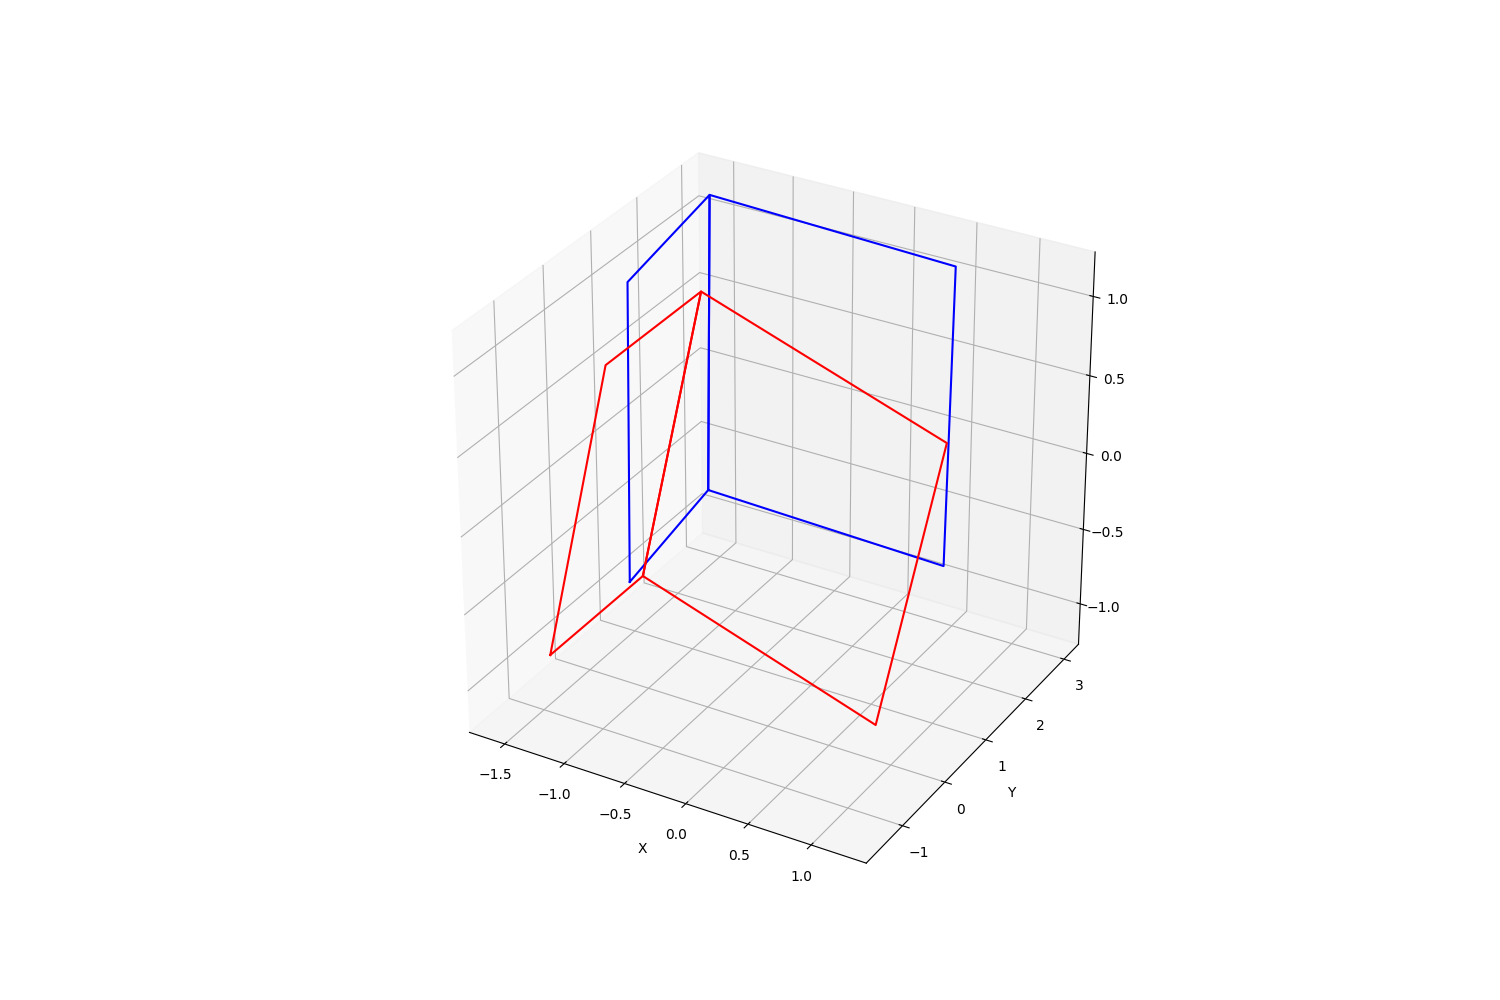

In [21]:
plot_P = np.vstack((np.eye(3), -np.eye(3)))
ax = plot_3D_setup(P=plot_P)
P_T.plot(ax, color='b')
Q.plot(ax, color='r')

Test with R as state and updating R thru exponential map

In [11]:
from planeslam.geometry.plane import BoundedPlane
from planeslam.registration import expmap
from planeslam.scan import Scan
import copy

V1 = np.array([[-1, 1, -1],
              [1, 1, -1],
              [1, 1, 1],
              [-1, 1, 1]])
V2 = np.array([[-1, -1, -1],
              [-1, 1, -1],
              [-1, 1, 1],
              [-1, -1, 1]])
P = Scan([BoundedPlane(V1), BoundedPlane(V2)])

# Ground-truth transformation
t = np.array([0, -0.5, 0])[:,None]
u = np.array([0, 1, 0])[:,None]
theta = np.pi/12
q = np.vstack((t, theta*u))

R = expmap(q[3:].flatten())

print("t: ", t)
print("R: ", R)

# P is source, Q is target
Q = copy.deepcopy(P)
Q.transform(R, t.flatten())

correspondences = [(0,0), (1,1)]
n_s, d_s, n_t, d_t = extract_corresponding_features(P, Q, correspondences)

vertex and face generation not yet implemented
t:  [[ 0. ]
 [-0.5]
 [ 0. ]]
R:  [[ 0.96592583  0.          0.25881905]
 [ 0.          1.          0.        ]
 [-0.25881905  0.          0.96592583]]


In [12]:
# Initial transformation
t0 = np.array([0, 0.1, 0])[:,None]
R0 = np.eye(3)

# Gauss-Newton
n_iters = 5
lmbda = 1e-8

for i in range(n_iters):
    r, n_q = residual(n_s, d_s, n_t, d_t, R0, t0)
    J = jacobian(n_s, n_q)
    dq = -np.linalg.inv(J.T @ J + lmbda * np.eye(6)) @ J.T @ r
    print(r)
    t0 = t0 + dq[:3]
    R0 = expmap(dq[3:].flatten()) @ R0

print("t_est: ", t0)
print("R_est: ", R0)

[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.03407417]
 [ 0.        ]
 [ 0.25881905]
 [-0.6       ]
 [ 0.        ]]
[[ 0.12143545]
 [ 0.0081138 ]
 [-0.03761919]
 [-0.14845892]
 [ 0.12143545]
 [-0.30420963]
 [-0.56539092]
 [ 0.00800573]]
[[ 0.07392445]
 [ 0.00489462]
 [ 0.06557788]
 [-0.42985871]
 [-0.0157984 ]
 [-0.58520847]
 [-0.71388244]
 [-0.01044872]]
[[ 0.07086241]
 [ 0.06503652]
 [ 0.34759431]
 [-0.83155396]
 [-0.33634645]
 [-0.67328356]
 [-1.11013494]
 [-0.20547364]]
[[ 0.21080837]
 [ 0.20415827]
 [ 0.56762291]
 [-1.30351947]
 [-0.60421685]
 [-0.46295137]
 [-1.7790153 ]
 [-0.77017013]]
t_est:  [[-0.15018611]
 [ 2.99139998]
 [-0.29983518]]
R_est:  [[-0.19305103 -0.15156355  0.96941208]
 [-0.53786736  0.84266944  0.02463567]
 [-0.82062781 -0.51665918 -0.24419929]]
